In [87]:
## trying around with the pyDDM library
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from ddm import Fittable, Model, Sample, Bound, set_N_cpus
from ddm.models import LossRobustBIC, DriftConstant, NoiseConstant, BoundConstant, OverlayNonDecision, Drift
from ddm.functions import fit_adjust_model, display_model
import ddm.plot

import pickle

path_models = '../2-3_Fitted/pyDDM_Models/'


## define colormaps for plotting
# go/nogo cm
g_cm = plt.cm.get_cmap('BrBG')
# correct/incorrect response (performance)
p_cm = plt.cm.get_cmap('RdYlGn')
# trial condition cmap(hit, pass)
c_cm = plt.cm.get_cmap('PuOr')


In [46]:
my_file = pd.read_csv('../2_cleaned/df_verbose.csv', sep = ',')

,goalPosDegCen,difficulty,in_out,up_down,samplePosDegCen_01,samplePosDegCen_02,samplePosDegCen_03,samplePosDegCen_04,samplePosDegCen_05,samplePosDegCen_06,...,sampleAccprobHit_03,sampleAccprobHit_04,sampleAccprobHit_05,sampleAccprobHit_06,sampleProbHit_01,sampleProbHit_02,sampleProbHit_03,sampleProbHit_04,sampleProbHit_05,sampleProbHit_06
0,2,1.809975,1,-1,0.301258,3.225335,2.362545,1.703039,-0.261664,0.700806,...,0.190052,0.190052,0.213758,0.213758,0.486096,0.120586,0.228435,0.310873,0.556461,0.436152
1,2,1.847432,-1,-1,-0.822462,5.460380,5.465482,0.879874,-0.565124,2.491225,...,1.000000,1.000000,1.000000,1.000000,0.916263,0.298381,0.297744,0.870945,0.948431,0.669526
2,2,1.929658,-1,1,3.746282,0.868587,-1.166560,-1.477911,1.467197,5.791083,...,0.895029,0.883255,0.883255,1.000000,0.959492,0.599781,0.345387,0.306468,0.674607,0.784907
3,-2,1.834521,-1,-1,-3.330029,-0.337660,0.971259,1.627050,-5.873847,1.302279,...,0.774124,0.725445,1.000000,1.000000,0.895569,0.521523,0.357908,0.275934,0.786454,0.316530
4,4,1.920750,1,1,4.869227,3.625997,5.868832,5.287595,5.330901,2.434693,...,0.296196,0.296196,0.296196,0.112562,0.368560,0.213156,0.493510,0.420856,0.426269,0.064243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9584,2,1.982123,-1,1,4.456436,2.318772,-0.742732,4.046430,2.954920,4.563570,...,1.000000,1.000000,1.000000,1.000000,0.945180,0.787612,0.404924,0.996431,0.867130,0.931788
9585,4,1.899154,-1,-1,0.063404,5.288069,6.721251,6.232631,6.704509,0.875458,...,1.000000,1.000000,1.000000,1.000000,0.770531,0.576386,0.397238,0.458315,0.399331,0.872038
9586,0,1.961706,-1,1,0.708903,-0.927350,-0.761635,-2.777155,-3.261583,0.442904,...,0.791099,0.705492,0.670087,0.670087,0.833826,0.629295,0.650009,0.398069,0.337515,0.800576
9587,-2,1.844734,-1,1,0.183733,-3.739433,-2.346879,-1.617489,-0.286732,-1.663975,...,1.000000,1.000000,1.000000,1.000000,0.996442,0.513163,0.687232,0.778406,0.944750,0.772595


In [47]:
# import my file
my_file = pd.read_csv('../2_cleaned/df_verbose.csv', sep = ',')
# reduce to one subject
my_file = my_file[my_file.subject == 'AD']
# compute an answer variable
my_file['answer'] = 1-abs(my_file.goResp - my_file.hitGoal) 
# compute the reaction time in ms
my_file.loc[:,'handmoveTimeMsGo'] = my_file['handmoveTimeMsGo']/1000 

# drift diffusion models track the evidence for one output over another.
# in this implementation, the upper bound represents a correct outcome, the lower bound represents an incorrect outcome
# therefore, we need to scale our evidence (probability of a hit) such that it reflects the similarity to the true outcome 
# of the trial. (Large, when there is no difference between the true outcome and the evidence), 0 when it's neutral, 1 when 
# there's evidence for the opposite outcome

my_file.loc[:,'sampleProbHit_01'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_01']))
my_file.loc[:,'sampleProbHit_02'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_02'])) 
my_file.loc[:,'sampleProbHit_03'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_03'])) 
my_file.loc[:,'sampleProbHit_04'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_04'])) 
my_file.loc[:,'sampleProbHit_05'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_05'])) 
my_file.loc[:,'sampleProbHit_06'] = 2 * (0.5 - abs(my_file['hitGoal']-my_file['sampleProbHit_06'])) 

full_file = my_file.copy()

# only get 'go responses'
my_file = my_file[my_file.goResp == 1]

# reduce my data file to the neccesary columns
my_file = my_file.loc[:,['handmoveTimeMsGo', 'answer', 'sampleProbHit_01', 'sampleProbHit_02', 'sampleProbHit_03', 'sampleProbHit_04', 'sampleProbHit_05', 'sampleProbHit_06', 'hitGoal', 'response_cat']]

# drop all rows that contain nans and reset the index 
my_file.dropna(axis = 0, inplace = True)
my_file.reset_index(drop = True, inplace = True)

sample_file = my_file.copy()
sample_file = sample_file.loc[:,['handmoveTimeMsGo', 'answer', 'sampleProbHit_01', 'sampleProbHit_02', 'sampleProbHit_03', 'sampleProbHit_04', 'sampleProbHit_05', 'sampleProbHit_06', 'hitGoal']]

# turn my datafile into a pyDDM sample
sample = Sample.from_pandas_dataframe(sample_file, rt_column_name="handmoveTimeMsGo", correct_column_name="answer")

In [3]:
my_file

,handmoveTimeMsGo,answer,sampleProbHit_01,sampleProbHit_02,sampleProbHit_03,sampleProbHit_04,sampleProbHit_05,sampleProbHit_06,hitGoal,response_cat
0,0.432,0,0.027808,0.758827,0.543130,0.378254,-0.112922,0.127695,0,FALSE ALARM
1,0.450,1,0.832526,-0.403237,-0.404513,0.741890,0.896861,0.339052,1,HIT
2,0.433,1,0.918985,0.199561,-0.309226,-0.387063,0.349214,0.569815,1,HIT
3,0.625,1,0.791138,0.043045,-0.284184,-0.448132,0.572908,-0.366939,1,HIT
4,0.450,0,0.262881,0.573688,0.012979,0.158289,0.147462,0.871514,0,FALSE ALARM
...,...,...,...,...,...,...,...,...,...,...
1280,0.450,1,0.157540,-0.162143,-0.103252,0.654341,0.571089,0.811457,1,HIT
1281,0.433,1,0.754857,0.968415,0.281900,-0.064023,0.832240,0.102292,1,HIT
1282,0.658,1,-0.348743,-0.383803,0.737791,0.982879,0.078622,0.021211,1,HIT
1283,0.691,1,-0.327255,-0.498186,0.248610,-0.176462,0.909321,0.783522,1,HIT


In [4]:
class BoundCollapsingExponentialDelay(Bound):
    """Bound collapses exponentially over time.

    Takes three parameters: 

    `B` - the bound at time t = 0.
    `tau` - the time constant for the collapse, should be greater than
    zero.
    `t1` - the time at which the collapse begins, in seconds
    """
    name = "Delayed exponential collapsing bound"
    required_parameters = ["B", "tau", "t1"]
    def get_bound(self, t, conditions, **kwargs):
        if t <= self.t1:
            return self.B
        if t > self.t1:
            return self.B * np.exp(-self.tau*(t-self.t1))

In [5]:
modelsimple = Model(name='drift rate depends on first tw (fitted)',
                  drift = DriftConstant(drift = Fittable(minval = 0.5, maxval = 5)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundConstant(B = 1),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=1)

fit_adjust_model(sample, modelsimple, lossfunction=LossRobustBIC, verbose=False)

Params [2.78291928 1.76932804 0.3091817 ] gave -652.7831505586122


Model(name='drift rate depends on first tw (fitted)', drift=DriftConstant(drift=Fitted(2.7829192792318675, minval=0.5, maxval=5)), noise=NoiseConstant(noise=Fitted(1.7693280411543815, minval=0.5, maxval=4)), bound=BoundConstant(B=1), IC=ICPointSourceCenter(), overlay=OverlayNonDecision(nondectime=Fitted(0.3091816987512049, minval=0, maxval=1)), dx=0.001, dt=0.01, T_dur=1, fitresult=FitResult(fitting_method='differential_evolution', method='auto', loss='BIC', value=-652.7831505586122, nparams=3, samplesize=1285, mess=''))

In [6]:
## define a drift class for the first model
class FirstValDrift(Drift):
    name = "returns drift of first value"
    required_conditions = ["sampleProbHit_01"]
    required_parameters = ["scale"]
    def get_drift(self, t, conditions, **kwargs):
        return conditions['sampleProbHit_01']*self.scale

In [7]:
with open(path_models + 'model1.pkl', 'rb') as input:
    modeltest = pickle.load(input)

In [8]:
model1_fit = Model(name='drift rate depends on first tw (fitted)',
                  drift= FirstValDrift(scale = Fittable(minval=1, maxval=10)),
                #drift = DriftConstant(drift = Fittable(minval = 0.5, maxval = 5)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundCollapsingExponentialDelay(B=1,
                                           tau=Fittable(minval=0.1, maxval=5),
                                           t1=Fittable(minval=0, maxval=1)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=1)

# fit_adjust_model(sample, model1_fit, lossfunction=LossRobustBIC, verbose=False)

In [9]:
## define a drift class for the second model
class ThreshDrift(Drift):
    name = "drifts with the first value above threshold"
    required_conditions = ["sampleProbHit_01", "sampleProbHit_02", "sampleProbHit_03", "sampleProbHit_04", "sampleProbHit_05", "sampleProbHit_06"]
    required_parameters = ["scale","thresh"]
    drift_value = 0
    time_schema = np.linspace(0, 0.88, 6)
    def get_drift(self, t, conditions, **kwargs):
        passed = self.time_schema[(self.time_schema - t)<=0]
        prob = self.required_conditions[np.argmax(passed)]
        if (conditions[prob] > self.thresh) and (self.drift_value == 0):
            ThreshDrift.drift_value = conditions[prob]*self.scale
        return self.drift_value

In [10]:
## define the second model
modeltwo_fit = Model(name='drift starts after threshold was crossed',
                  drift= ThreshDrift(scale = Fittable(minval=1, maxval=10),thresh = Fittable(minval = 0.1, maxval = 1)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundCollapsingExponentialDelay(B=1,
                                           tau=Fittable(minval=0.1, maxval=5),
                                           t1=Fittable(minval=0, maxval=1)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=1)

#fit_adjust_model(sample, model2_fit,lossfunction=LossRobustBIC, verbose=False)

In [11]:
# Define the Drift for the Third Model
class ContinuousUpdate(Drift):
    name = "continuously updating drifts"
    required_conditions = ["sampleProbHit_01", "sampleProbHit_02", "sampleProbHit_03", "sampleProbHit_04", "sampleProbHit_05", "sampleProbHit_06"]
    required_parameters = ["scale"]
    time_schema = np.linspace(0,1,6)
    def get_drift(self, t, conditions, **kwargs):
        passed = self.time_schema[(self.time_schema - t)<=0]
        prob = self.required_conditions[np.argmax(passed)]
        return conditions[prob]*self.scale

In [12]:
## define the third model
modelthree_fit = Model(name='drift changes with every new sample',
                  drift= ContinuousUpdate(scale = Fittable(minval=1, maxval=10)),
                  noise=NoiseConstant(noise=Fittable(minval=.5, maxval=4)),
                  bound=BoundCollapsingExponentialDelay(B=1,
                                           tau=Fittable(minval=0.1, maxval=5),
                                           t1=Fittable(minval=0, maxval=1)),
                  overlay=OverlayNonDecision(nondectime=Fittable(minval=0, maxval=1)),
                  dx=.001, dt=.01, T_dur=1)

#fit_adjust_model(sample, model3_fit,lossfunction=LossRobustBIC, verbose=False)

In [80]:
fit_file = full_file.copy()
m1_df = fit_file.copy()
m2_df = fit_file.copy()
m3_df = fit_file.copy()

## solve the models for every trial, get an estimate of the response time, and of a true/false answer
# finally, get the answer by comparing true/false to the condition


for r in fit_file.index:

    conditions = {
        'sampleProbHit_01': fit_file.loc[r, 'sampleProbHit_01']
    }

    simpleSolution = modelsimple.solve(conditions = conditions)
    testSolution = modeltest.solve(conditions = conditions)

    m1_df.loc[r,'handmoveTimeMsGo'] = simpleSolution.resample(1) 
    m1_df.loc[r,'probAnswer'] = simpleSolution.prob_correct()

    m2_df.loc[r,'handmoveTimeMsGo'] =  testSolution.resample(1)
    m2_df.loc[r,'probAnswer'] =  testSolution.prob_correct()

m1_df.loc[:,'answer'] = np.round(m1_df.probAnswer)
m2_df.loc[:,'answer'] = np.round(m2_df.probAnswer)

m1_df.loc[:,'goResp'] = 1 - (abs(m1_df.answer - m1_df.hitGoal))
m2_df.loc[:,'goResp'] = 1 - (abs(m2_df.answer - m2_df.hitGoal))

Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather than 1
Warning, distribution sums to 1.000000 rather 

In [81]:
for ix in m1_df.index:
    if m1_df.loc[ix,'goResp'] == 1:
        if m1_df.loc[ix,'hitGoal'] == 1:
            m1_df.loc[ix,'response_cat'] = 'HIT'
        else:
            m1_df.loc[ix,'response_cat'] = 'FALSE ALARM'
    else:
        if m1_df.loc[ix,'hitGoal'] == 1:
            m1_df.loc[ix,'response_cat'] = 'MISS'
        else:
            m1_df.loc[ix,'response_cat'] = 'CORRECT REJECTION'

for ix in m2_df.index:
    
    if m2_df.loc[ix,'goResp'] == 1:
        if m2_df.loc[ix,'hitGoal'] == 1:
            m2_df.loc[ix,'response_cat'] = 'HIT'
        else:
            m2_df.loc[ix,'response_cat'] = 'FALSE ALARM'
    else:
        if m2_df.loc[ix,'hitGoal'] == 1:
            m2_df.loc[ix,'response_cat'] = 'MISS'
        else:
            m2_df.loc[ix,'response_cat'] = 'CORRECT REJECTION'
            

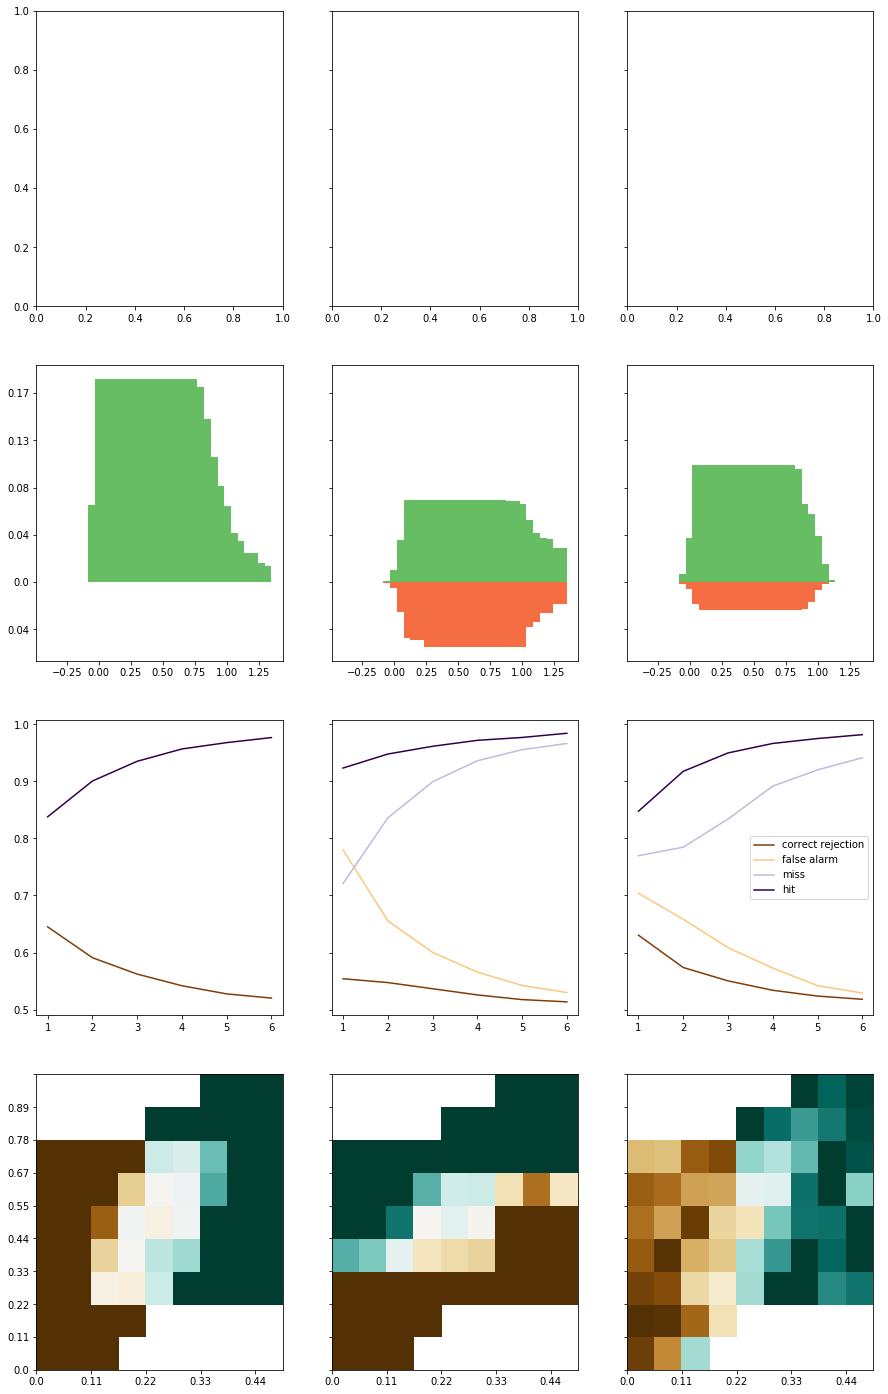

In [100]:
# make one large plot to compare the model predicitions to the actual data.

f2, a2 = plt.subplots(4,3, figsize = (15,25), sharex = 'row', sharey = 'row')


# define the bins for count plots
bins = np.linspace(0,1,20)

# define response types
responses = ['CORRECT REJECTION', 'FALSE ALARM', 'MISS', 'HIT']

# define probability windows
n_pwins = 10
window_prob = np.linspace(min(fit_file.sampleAccprobHit_01),max(fit_file.sampleAccprobHit_01),n_pwins)

for m_id, m_df in enumerate([m1_df, m2_df, fit_file]):

    # first plot: distribution correct & incorrect reaction times
    # filter correct and incorrect reaction times
    RTs_c = m_df[m_df.answer == 1].handmoveTimeMsGo
    RTs_i = m_df[m_df.answer == 0].handmoveTimeMsGo

    # get histograms
    CountRTs_c = np.histogram(RTs_c[~np.isnan(RTs_c)], bins = bins)[0]
    CountRTs_i = -1 *np.histogram(RTs_i[~np.isnan(RTs_i)], bins = bins)[0]
    
    # plot everything
    a2[1,m_id].bar(bins[:-1],CountRTs_c, color = p_cm(0.8))
    a2[1,m_id].bar(bins[:-1],CountRTs_i, color = p_cm(0.2))
    

    # second plot: mean hit probabilities before each response
    # initialize data frames
    value_respcat_fw = pd.DataFrame()
    
    # time information relative to go response
    for timewin in range(1,7):
        
        time_col = 'sampleAccprobHit_0{}'.format(timewin)

        # loop through response categories
        for respcat in responses:
            # get mean probability for category and time value
            value_respcat_fw.loc[respcat, timewin] = (np.mean(m_df.loc[m_df.response_cat == respcat,time_col])/2)+0.5
            
    # plot
    for row, c in zip(responses, c_cm(np.linspace(0, 1, len(responses)))):
        a2[2, m_id].plot(range(1,7),value_respcat_fw.loc[row,:], label = row.lower(), color = c)
        
    
    ## third plot: reproduce the decision after evidence pattern
    # translate df into long data frame
    
    # in order to match the trials later, we want an ID
    m_df['ids'] = m_df.index
    # melt the data frame into long format
    long_m_df = m_df.melt(id_vars=['goResp', 'hitGoal', 'ids'], value_vars=['sampleAccprobHit_01','sampleAccprobHit_02','sampleAccprobHit_03','sampleAccprobHit_04','sampleAccprobHit_05','sampleAccprobHit_06'], var_name='sampleID', value_name='sampleAccprobHit')

    # define a panda data frame to store the values:
    # intitialize the data frames
    change_fw = pd.DataFrame()
        
    # filter data from this tw
    ctw_fw = long_m_df[long_m_df.sampleID == 'sampleAccprobHit_01']
    
    # filter data from the next tw
    ntw_fw = long_m_df[long_m_df.sampleID == 'sampleAccprobHit_02']
        
    # go through all probabilites in tw 1
    for p_start in range(0, n_pwins-1):
    
        pst_low =  window_prob[p_start]
        pst_up = window_prob[p_start + 1]
        
        # get all IDs that fullfill the trial 
        start_IDs_fw = ctw_fw.iloc[np.where((ctw_fw.sampleAccprobHit >= pst_low)&(ctw_fw.sampleAccprobHit < pst_up))[0]]['ids']
                
        # go through all probabilities in the next time window
        for p_end in range(0, n_pwins-1):
            
            pend_low =  window_prob[p_end]
            pend_up = window_prob[p_end + 1]
            
            # get all ids that fullfill the end probability requirement
            end_IDs_fw = ntw_fw.iloc[np.where((ntw_fw.sampleAccprobHit >= pend_low)&(ntw_fw.sampleAccprobHit < pend_up))[0]]['ids']
        
            # get the intercept between the two lists
            ID_list_fw = np.intersect1d(start_IDs_fw, end_IDs_fw)
            
            
            # filter the dataframe
            df_fw = long_m_df.loc[np.where(long_m_df.ids.isin(ID_list_fw))]
            
            
            change_fw.loc[window_prob[p_start],window_prob[p_end]] = np.mean(df_fw.goResp)
            
    # plot
    a2[3,m_id].pcolormesh(change_fw, cmap = g_cm)
    
    
    
# Use absolute value for y-ticks
# change the axis ticks
ticks =  a2[1,m_id].get_yticks()
a2[1,m_id].set_yticklabels([np.round(abs(tick/len(m_df)),2) for tick in ticks]);
a2[2,2].legend()

a2[3,1].set_yticklabels(np.round(change_fw.columns, 2))
a2[3,1].set_xticklabels(np.round(change_fw.index, 2));

